In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # To show the interactive widgets 
# %matplotlib widget
# from Pyriod import Pyriod #!This hates me. So just using LK
# import warnings

# # Suppress warning from Astropy module 
# # astropy.stats used in Pyriod is no longer supported
# from astropy.utils.exceptions import AstropyDeprecationWarning
# warnings.filterwarnings("ignore", category=AstropyDeprecationWarning)

# # Suppress invalid value runtime warning from Astropy and Pyriod 
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

# from IPython.display import Image

# import lightkurve as lk

1.0094460274770178 d


<AxesSubplot: xlabel='Time [JD]', ylabel='Normalized Flux'>

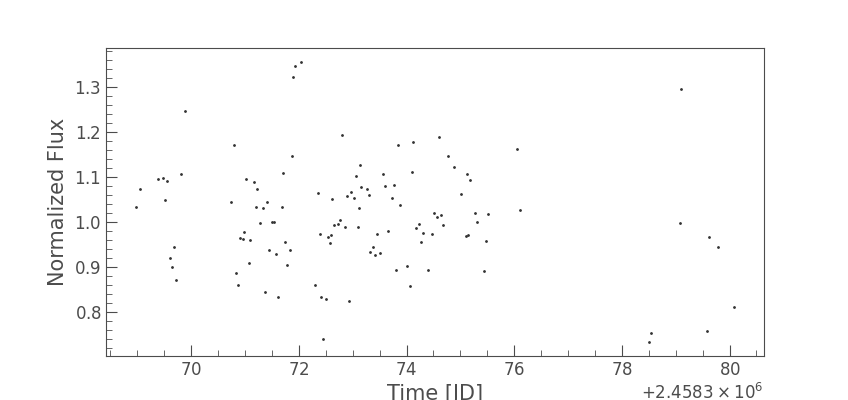

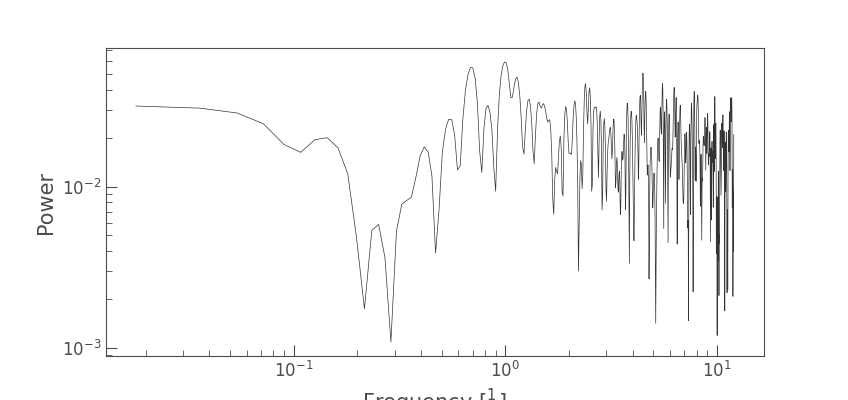

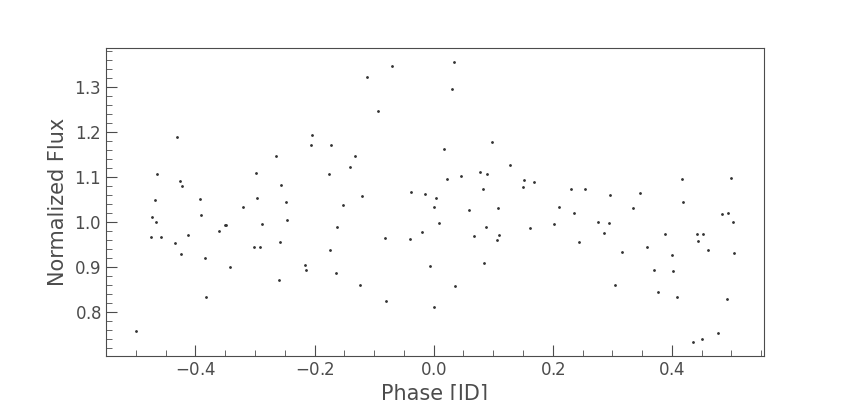

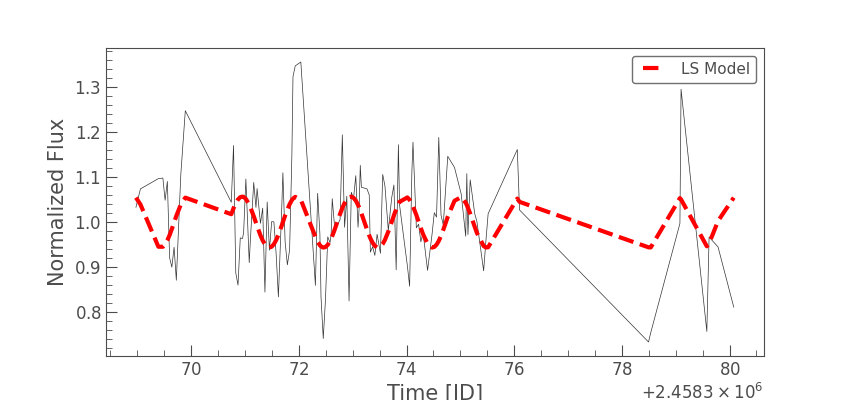

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
import astropy.units as u
%matplotlib widget


data = pd.read_csv("./ 2000 KR32 Matches.csv")

fluxes = data["flux"]
times = data["Time"]

fluxErrs = np.ones_like(fluxes)*1e-4 #lk needs errors

lc =lk.LightCurve(data=None, time=times, flux=fluxes, flux_err=fluxErrs)
lc = lc.normalize()
lc.scatter()
pg = lc.to_periodogram()

pg.plot(scale="log")
period = pg.period_at_max_power
print(period)
lc.fold(period).scatter()

lcModel = pg.model(time=lc.time, frequency=pg.frequency_at_max_power)
ax = lc.plot()
lcModel.plot(ax=ax, lw=3, ls='--',c='red')

0.13364980406270774 d


<AxesSubplot: xlabel='Phase [JD]', ylabel='Flux'>

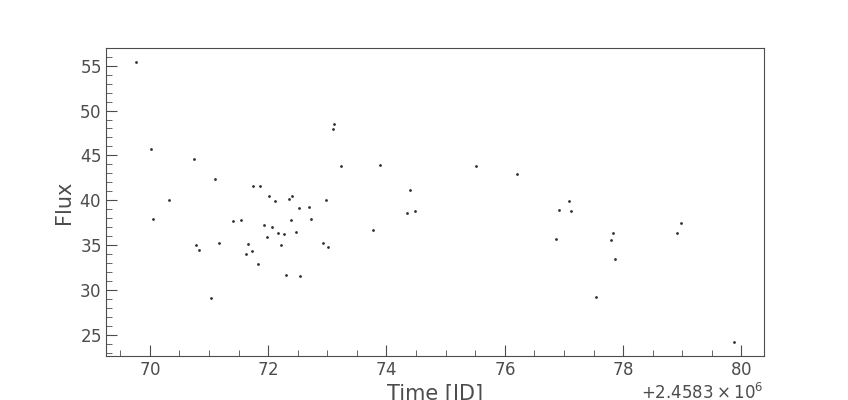

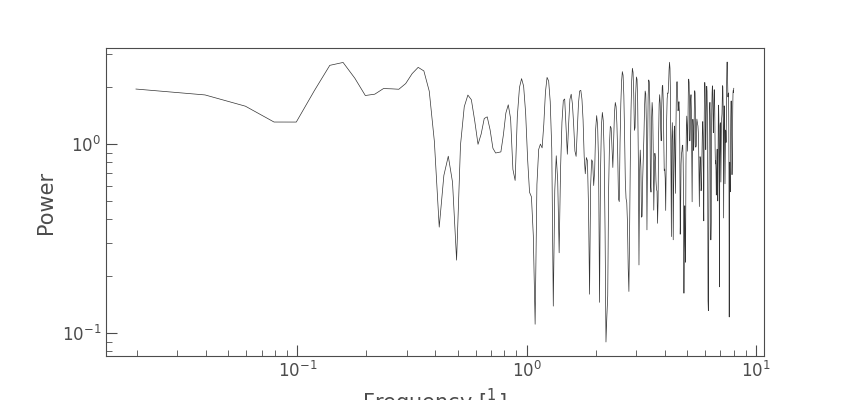

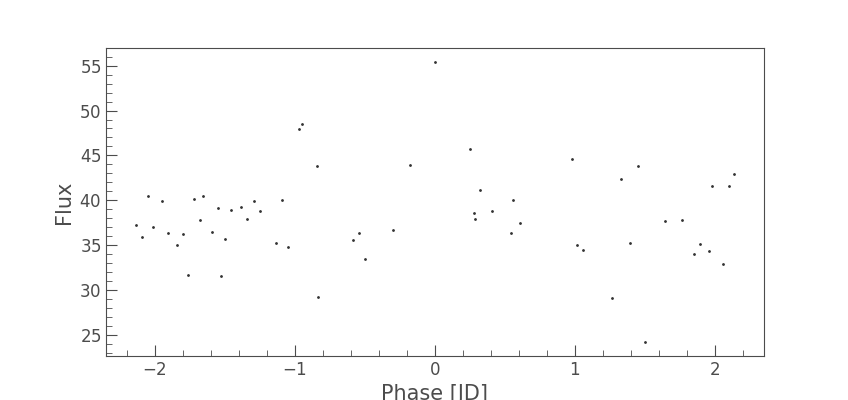

In [7]:
data = pd.read_csv("./ 2001 OH96 Matches.csv")

fluxes = data["flux"]
times = data["Time"]

fluxErrs = np.ones_like(fluxes)*1e-4 #lk needs errors

lc =lk.LightCurve(data=None, time=times, flux=fluxes, flux_err=fluxErrs)

lc.scatter()
pg = lc.to_periodogram()

pg.plot(scale="log")
period = pg.period_at_max_power
print(period)
lc.fold(4.3).scatter()